In [ ]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences




In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!nvidia-smi

Wed Feb  9 17:36:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
cd drive/MyDrive/text_summerization/

/content/drive/MyDrive/text_summerization


In [ ]:

data = pd.read_csv('Reviews.csv')
reviews = data[['Summary','Text']]
reviews.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
reviews.isnull().sum()

Summary    27
Text        0
dtype: int64

In [ ]:
reviews = reviews.dropna()

In [ ]:
from sklearn.utils import shuffle
# shuffling the data 
reviews = shuffle(reviews)
reviews = reviews.reset_index(drop=True)
reviews.head()

,Summary,Text
0,Tried a second time and it was great!,My husband bought me the Kuereg so I could mak...
1,Great tasting tuna,This is very good quality tuna fillet and is s...
2,Need to seal the tops better,Granted that I live nearly 2 miles above sea l...
3,GREAT product,I have really bad arthritis and usually have t...
4,Great stuff,"Having only eaten instant oatmeal, I was looki..."


In [ ]:
summary, review_text = pd.DataFrame(), pd.DataFrame()
summary['Summary'] = reviews['Summary']
review_text['Text'] = reviews['Text']

In [ ]:
contraction_mapping = np.load('contraction_mapping.npy', allow_pickle=True).item()
(short,long) = next(iter(contraction_mapping.items()))
print('short form:', short, ';  long form:', long)

short form: ain't ;  long form: is not


In [ ]:
stop_words = set(stopwords.words('english')) 

In [ ]:
def clean_data(text, remove_stopwords=False):
    
    # Make all words lowercase
    text = str(text).lower()
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    
    text = text.split()
    
    # Remove stopwords that are not important for the meaning of a sentence
    if(remove_stopwords):
        new_text = []
        for word in text:
            if word in stop_words:
                continue
            else:
                new_text.append(word)
        text = new_text
    
    # Replace contractions with their longer forms 
    new_text = []
    for word in text:
        if word in contraction_mapping:
            new_text.append(contraction_mapping[word])
        else:
            new_text.append(word)
    text = " ".join(new_text)
      
    text = re.sub(r'\'', ' ', text)
    
    return text
    

In [ ]:
summary['Summary'] = summary['Summary'].apply(lambda x: clean_data(x, remove_stopwords=True))
review_text['Text'] = review_text['Text'].apply(lambda x: clean_data(x, remove_stopwords=True))

In [ ]:
summary.head()

,Summary
0,tried second time great
1,great tasting tuna
2,need seal tops better
3,great product
4,great stuff


In [ ]:
review_text.head()

,Text
0,husband bought kuereg could make flavored coff...
1,good quality tuna fillet superior national bra...
2,granted live nearly 2 miles sea level packagin...
3,really bad arthritis usually take aleve everyd...
4,eaten instant oatmeal looking whole grain oatm...


In [ ]:
reviews.head()

,Summary,Text
0,Tried a second time and it was great!,My husband bought me the Kuereg so I could mak...
1,Great tasting tuna,This is very good quality tuna fillet and is s...
2,Need to seal the tops better,Granted that I live nearly 2 miles above sea l...
3,GREAT product,I have really bad arthritis and usually have t...
4,Great stuff,"Having only eaten instant oatmeal, I was looki..."


In [ ]:
# Remove data which only consists of stopwords.
ind = (summary['Summary']!='')&(review_text['Text']!='')
summary = summary[ind]
review_text = review_text[ind]

In [ ]:
def count_length(data):
    length = {}
    for text in data:
        l = len(text.split())
        if(l not in length):
            length[l] = 1
        else:
            length[l] += 1
    
    stats = np.zeros(max(length)+1)
    
    for i in length:
        stats[i] = length[i]
    total = np.sum(stats)
    cdf = np.cumsum(stats) / total
    
    return stats, cdf
    

In [ ]:
text_length, text_length_cdf = count_length(review_text['Text'])
summary_length, summary_length_cdf = count_length(summary['Summary'])

For long review texts, 90% of the data has <= 85 words, 95% of the data has <= 117 words,  and 99% of the data has <= 211 words


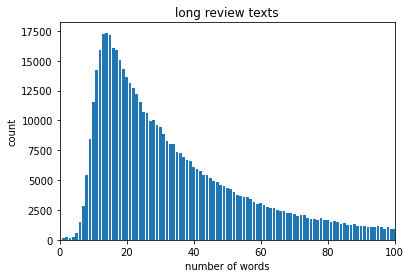

In [ ]:
plt.bar(np.arange(len(text_length)),text_length)
plt.ylabel('count')
plt.xlabel('number of words')
plt.xlim([0,100])
plt.title('long review texts')
print('For long review texts, 90% of the data has <=', np.sum(text_length_cdf<0.9), 'words,', '95% of the data has <=', np.sum(text_length_cdf<0.95), 'words,', ' and 99% of the data has <=', np.sum(text_length_cdf<0.99), 'words')

For summaries, 90% of the data has <= 5 words, 95% of the data has <= 6 words,  and 99% of the data has <= 8 words


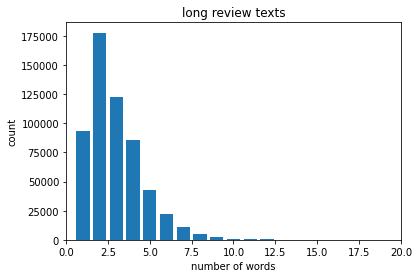

In [ ]:
plt.bar(np.arange(len(summary_length)),summary_length)
plt.ylabel('count')
plt.xlabel('number of words')
plt.xlim([0,20])
plt.title('long review texts')
print('For summaries, 90% of the data has <=', np.sum(summary_length_cdf<0.9), 'words,', '95% of the data has <=', np.sum(summary_length_cdf<0.95), 'words,', ' and 99% of the data has <=', np.sum(summary_length_cdf<0.99), 'words')

In [ ]:
start_token, end_token = '<SOS>' , '<EOS>'
summary['Summary'] = summary['Summary'].apply(lambda x: start_token + ' ' + x + ' ' + end_token)
review_text['Text'] = review_text['Text'].apply(lambda x: start_token + ' ' + x + ' ' + end_token)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(summary['Summary'].values)+list(review_text['Text']))

In [ ]:
def read_embedding(filename):
    
    embeddings_index = {}
    f = open(filename)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    return embeddings_index

In [ ]:
embeddings_index1 = read_embedding('glove.6B/glove.6B.50d.txt')
embeddings_index2 = read_embedding('numberbatch-en-19.08.txt')

In [ ]:
# Check how good the words in pre-trained embeddings cover the reviews
# calculate total number of words and unique words in the review
n_words = np.sum(list(tokenizer.word_counts.values()))
i_words = len(tokenizer.word_counts)

# calculate the number of words appearing larger than 3, 5, and 10 times in the review
i_words_3 = sum(count>3 for (word,count) in tokenizer.word_counts.items())
i_words_5 = sum(count>5 for (word,count) in tokenizer.word_counts.items())
i_words_10 = sum(count>10 for (word,count) in tokenizer.word_counts.items())

# calculate the percentage of the reviews consisting of words appear larger than 3, 5, and 10 times
n_words_3 = sum(count*(count>3) for (word,count) in tokenizer.word_counts.items())
n_words_5 = sum(count*(count>5) for (word,count) in tokenizer.word_counts.items())
n_words_10 = sum(count*(count>10) for (word,count) in tokenizer.word_counts.items())

# calculate the number of words appearing > 3,5,10 times in the reivew are covered by the pretrained embeddings
i_words_3_1 = sum((count>3 and word in embeddings_index1) for (word,count) in tokenizer.word_counts.items())
i_words_3_2 = sum((count>3 and word in embeddings_index2) for (word,count) in tokenizer.word_counts.items())
i_words_5_1 = sum((count>5 and word in embeddings_index1) for (word,count) in tokenizer.word_counts.items())
i_words_5_2 = sum((count>5 and word in embeddings_index2) for (word,count) in tokenizer.word_counts.items())
i_words_10_1 = sum((count>10 and word in embeddings_index1) for (word,count) in tokenizer.word_counts.items())
i_words_10_2 = sum((count>10 and word in embeddings_index2) for (word,count) in tokenizer.word_counts.items())

# caculate the percentage of the words in reviews appearing > 3,5,10 times are covered by the pretrained embeddings
n_words_3_1 = sum(count*(count>3 and word in embeddings_index1) for (word,count) in tokenizer.word_counts.items())
n_words_3_2 = sum(count*(count>3 and word in embeddings_index2) for (word,count) in tokenizer.word_counts.items())
n_words_5_1 = sum(count*(count>5 and word in embeddings_index1) for (word,count) in tokenizer.word_counts.items())
n_words_5_2 = sum(count*(count>5 and word in embeddings_index2) for (word,count) in tokenizer.word_counts.items())
n_words_10_1 = sum(count*(count>10 and word in embeddings_index1) for (word,count) in tokenizer.word_counts.items())
n_words_10_2 = sum(count*(count>10 and word in embeddings_index2) for (word,count) in tokenizer.word_counts.items())

In [ ]:
print("There are", i_words, "unique words in the reviews, the total word number is", n_words,'\n')

print(round(i_words_3/i_words,2)*100, '% of the unique words appear > 3 times.', round(n_words_3/n_words,3)*100, '% of the review words are these words. For words appearing > 3 times,', round(i_words_3_1/i_words_3,2)*100, '% are covered by the pretrained embedding glove-50,', round(n_words_3_1/n_words,3)*100, '% of the review words are these words.', round(i_words_3_2/i_words_3,2)*100, '% are covered by the pretrained embedding numberbatch,', round(n_words_3_2/n_words,3)*100, '% of the review words are these words.\n')

print(round(i_words_5/i_words,2)*100, '% of the unique words appear > 5 times.', round(n_words_5/n_words,3)*100, '% of the review words are these words. For words appearing > 5 times,', round(i_words_5_1/i_words_5,2)*100, '% are covered by the pretrained embedding glove-50,', round(n_words_5_1/n_words,3)*100, '% of the review words are these words.', round(i_words_5_2/i_words_5,2)*100, '% are covered by the pretrained embedding numberbatch,', round(n_words_5_2/n_words,3)*100, '% of the review words are these words.\n')

print(round(i_words_10/i_words,2)*100, '% of the unique words appear > 10 times.', round(n_words_10/n_words,3)*100, '% of the review words are these words. For words appearing > 10 times,', round(i_words_10_1/i_words_10,2)*100, '% are covered by the pretrained embedding glove-50,', round(n_words_10_1/n_words,3)*100, '% of the review words are these words.', round(i_words_10_2/i_words_10,2)*100, '% are covered by the pretrained embedding numberbatch,', round(n_words_10_2/n_words,3)*100, '% of the review words are these words.\n')


There are 116453 unique words in the reviews, the total word number is 27806392 

42.0 % of the unique words appear > 3 times. 99.7 % of the review words are these words. For words appearing > 3 times, 76.0 % are covered by the pretrained embedding glove-50, 98.8 % of the review words are these words. 73.0 % are covered by the pretrained embedding numberbatch, 97.8 % of the review words are these words.

34.0 % of the unique words appear > 5 times. 99.5 % of the review words are these words. For words appearing > 5 times, 81.0 % are covered by the pretrained embedding glove-50, 98.8 % of the review words are these words. 78.0 % are covered by the pretrained embedding numberbatch, 97.8 % of the review words are these words.

25.0 % of the unique words appear > 10 times. 99.2 % of the review words are these words. For words appearing > 10 times, 87.0 % are covered by the pretrained embedding glove-50, 98.6 % of the review words are these words. 84.0 % are covered by the pretrained embedd

In [ ]:
n = 20
missingwords = []
for (word,count) in tokenizer.word_counts.items():
    if(n>0 and word not in embeddings_index1 and count > 10):
        missingwords.append(word)
        n -= 1
print(missingwords)

['vinturi', 'landjaeger', 'tasts', 'chewies', 'disolves', 'gentlease', 'gfcf', 'caloire', 'tast', 'baconnaise', 'luzianne', 'delicous', 'softgels', 'decaff', 'goood', 'delish', 'tullys', 'whirley', 'glutino', 'evoo']


In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(review_text['Text']), np.array(summary['Summary']), test_size=0.1, random_state=0, shuffle=True) 

In [ ]:
tokenizer_model = Tokenizer(num_words=i_words_10+1, oov_token='<UNK>')
tokenizer_model.fit_on_texts(list(summary['Summary'].values)+list(review_text['Text']))

In [ ]:
tokenizer_model.texts_to_sequences(['<EOS> chocolove'])

[[3, 9245]]

In [ ]:
new_dict = {}
new_dict2 = {}
new_dict['<UNK>'] = 1
new_dict2[1] = '<UNK>'
label = 2
for (key, value) in tokenizer_model.word_index.items():
    if(key != '<UNK>' and tokenizer_model.word_counts[key]>10 and key in embeddings_index1):
        new_dict[key] = label
        label +=1
        new_dict2[value] = key

tokenizer_model.word_index = new_dict
tokenizer_model.index_word = new_dict2

tokenizer_model.texts_to_sequences(['<EOS> choclate'])

[[3, 1]]

In [ ]:
VOCAB_SIZE = len(new_dict) + 1

In [ ]:
#convert text sequences into integer sequences
x_tr_seq = tokenizer_model.texts_to_sequences(x_tr)
y_tr_seq = tokenizer_model.texts_to_sequences(y_tr)
x_val_seq = tokenizer_model.texts_to_sequences(x_val)
y_val_seq = tokenizer_model.texts_to_sequences(y_val)


In [ ]:
max_len_text = 100
max_len_summary = 10

#padding zero upto maximum length
x_tr_padded = pad_sequences(x_tr_seq,  maxlen=max_len_text, padding='post', truncating='post')
x_val_padded = pad_sequences(x_val_seq, maxlen=max_len_text, padding='post', truncating='post')
y_tr_padded = pad_sequences(y_tr_seq,  maxlen=max_len_summary, padding='post', truncating='post')
y_val_padded = pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post', truncating='post')

In [ ]:
BATCH_SIZE = 64
dataset_train = tf.data.Dataset.from_tensor_slices((x_tr_padded, y_tr_padded)).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.from_tensor_slices((x_val_padded,y_val_padded)).batch(BATCH_SIZE)

In [ ]:
def load_pretrained_embeddings(filename, embedding_dim=50, vocab_size=100000):
    
    if(filename=='glove.6B/glove.6B.50d.txt'):
        embedding_dim = 50
        vocab_size = VOCAB_SIZE
        embedding_matrix = np.zeros((vocab_size, embedding_dim))

        for word, i in tokenizer_model.word_index.items():
            embedding_vector = embeddings_index1.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        
        embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            trainable=False)
    
    return embedding_layer

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1, embedding_filename=None):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    if(embedding_filename):
      self.embedding = load_pretrained_embeddings(filename=embedding_filename)
    else:
      self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1, embedding_filename=None):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    if(embedding_filename):
      self.embedding = load_pretrained_embeddings(filename=embedding_filename)
    else:
      self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1, embedding_filename=None):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate,
                           embedding_filename=embedding_filename)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate,
                           embedding_filename=embedding_filename)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [ ]:
transformer_model = Transformer(num_layers=5,
                                d_model=50,
                                num_heads=5,
                                dff=512,
                                input_vocab_size=VOCAB_SIZE,
                                target_vocab_size=VOCAB_SIZE,
                                pe_input=max_len_text,
                                pe_target=max_len_text,
                                rate=0.15,
                                embedding_filename='glove.6B/glove.6B.50d.txt')

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=4000, decay_rate=0.95)
optimizer = Adam(lr_schedule , beta_1=0.9, beta_2=0.98, epsilon=1e-9) 
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')
#train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
def loss_function(real, pred):
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
def validate():
    #print('validation started ...')
    val_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(dataset_val):    
        tar_inp = tar[:, :-1] # <startseq> hi im moein
        tar_real = tar[:, 1:] # hi im moein <endseq>
        predictions, _ = transformer_model(inputs=[inp, tar_inp], training=False)
        loss = loss_function(tar_real, predictions)
        val_loss(loss)
    #print('\n* Validation loss: {} '.format(val_loss.result()) )
    return val_loss.result()

In [ ]:
@tf.function # Compiles a function into a callable TensorFlow graph
def train_step(inp, tar):
    tar_inp = tar[:, :-1] 
    tar_real = tar[:, 1:] 

    #enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer_model(inputs=[inp, tar_inp], training=True)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer_model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer_model.trainable_variables))
    
    train_loss(loss)

In [ ]:
EPOCHS = 50
history = {'train_loss':[], 'val_loss':[]}

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    #train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(dataset_train):
        train_step(inp, tar)
        if batch % 2000 == 0:
            #validate_loss = validate().numpy()
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Time {time.time() - start:.2f} secs')
            #print(f'Epoch {epoch + 1} Batch {batch} Train Loss {train_loss.result():.4f} Valication Loss {validate_loss:.4f} Time {time.time() - start:.2f} secs')
    trained_loss = train_loss.result().numpy()
    validate_loss = validate().numpy()
    history['train_loss'].append(trained_loss)
    history['val_loss'].append(validate_loss)
    print(f'Epoch {epoch + 1} Batch {batch} Train Loss {train_loss.result():.4f} Valication Loss {validate_loss:.4f} Time {time.time() - start:.2f} secs')

Epoch 1 Batch 0 Loss 10.1537 Time 11.77 secs
Epoch 1 Batch 2000 Loss 6.4916 Time 82.07 secs
Epoch 1 Batch 4000 Loss 5.9695 Time 152.26 secs
Epoch 1 Batch 6000 Loss 5.7547 Time 222.47 secs
Epoch 1 Batch 7954 Train Loss 5.6224 Valication Loss 5.1204 Time 448.79 secs
Epoch 2 Batch 0 Loss 5.2982 Time 0.17 secs
Epoch 2 Batch 2000 Loss 5.1326 Time 70.39 secs
Epoch 2 Batch 4000 Loss 5.0968 Time 140.57 secs
Epoch 2 Batch 6000 Loss 5.0675 Time 210.82 secs
Epoch 2 Batch 7954 Train Loss 5.0441 Valication Loss 4.9057 Time 431.01 secs
Epoch 3 Batch 0 Loss 5.0980 Time 0.10 secs
Epoch 3 Batch 2000 Loss 4.9407 Time 70.35 secs
Epoch 3 Batch 4000 Loss 4.9211 Time 140.59 secs
Epoch 3 Batch 6000 Loss 4.9042 Time 210.83 secs
Epoch 3 Batch 7954 Train Loss 4.8899 Valication Loss 4.7807 Time 429.85 secs
Epoch 4 Batch 0 Loss 4.9511 Time 0.10 secs
Epoch 4 Batch 2000 Loss 4.8245 Time 70.33 secs
Epoch 4 Batch 4000 Loss 4.8070 Time 140.56 secs
Epoch 4 Batch 6000 Loss 4.7928 Time 210.80 secs
Epoch 4 Batch 7954 Trai

KeyboardInterrupt: ignored

In [ ]:
def validate():
    print('validation started ...')
    val_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(dataset_val):    
        tar_inp = tar[:, :-1] 
        tar_real = tar[:, 1:] 
        predictions, _ = transformer_model(inputs=[inp, tar_inp], training=False)
        loss = loss_function(tar_real, predictions)
        val_loss(loss)
    print('\n* Validation loss: {} '.format(val_loss.result()) )
    
    return val_loss.result()

In [ ]:
def evaluate(input_document):
    input_document = tokenizer_model.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=max_len_text, 
                                                                           padding='post', truncating='post')
    
    encoder_input = tf.expand_dims(input_document[0], 0)
    start_token = 'sos'
    decoder_input = [tokenizer_model.word_index[start_token]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_len_summary):
        
        predictions, attention_weights = transformer_model(inputs=[encoder_input, output], training = False)

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # stop prediciting if it reached end_token
        end_token = 'eos'
        if predicted_id == tokenizer_model.word_index[end_token]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # remove start_token
    return tokenizer_model.sequences_to_texts(summarized)[0]  # since there is just one translated document

In [ ]:
i1 = 65
print(x_tr[i1])
print(summarize(clean_data(x_tr[i1])))

<SOS> wonderful combination flavors proves heaven truly exists fan salt vinegar chips love almonds i have 2 cases counting shhhhhhhh <EOS>
best chips ever


In [ ]:
transformer_model.summary()